In [ ]:
# Imports
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import string
import timeit
import torch
from torch import nn
import torch.functional as F
import torch.nn.functional as F
import re
import os
import sys
import warnings

# To store in and import files from google drive

# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
# data_file_location = "/content/gdrive/MyDrive/nn_dataset/final/"
# os.chdir(data_file_location)

# end of google drive mount related code

print(f'Current Directory: {os.getcwd()}')

# arr = os.listdir()
# print(', '.join(arr))

from nn_utils import * # Contains all the model 
import nn_common as nnc

warnings.filterwarnings('ignore')

Mounted at /content/gdrive/
Current Directory: /content/gdrive/.shortcut-targets-by-id/1-aAopK3Hh5Cd6pFxyYKskeHYiZlx_nLT/nn_dataset/final


# Load Hindi Dataset
---
Given a dataset path and its stopwords' path the `DataContext` class reads the data makes it training ready.

Preprocessing started
Preprocessing finished.
Preprocessing Took 0.8214698520000638 Seconds


count    4665.000000
mean       17.702465
std         9.683710
min         0.000000
25%        10.000000
50%        15.000000
75%        25.000000
max        69.000000
Name: preprocessed_sen_len, dtype: float64


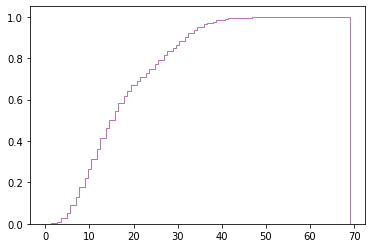


Vocabularies length: 18171


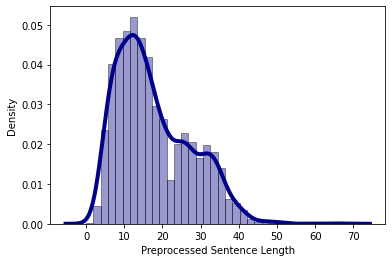

In [ ]:
hindi_dc = DataContext()
hindi_dc.load_and_preprocess_data("data/hindi_hatespeech.tsv", "data/stopwords-hi.txt", "\t")
hindi_dc.create_target(label_colum_name = "task_1", positive_value = "HOF")
hindi_dc.build_vocab()
hindi_dc.convert_word_to_index()

# a) Binary neural sentiment classifier : Hindi

Define params and load the embedding matrix

In [ ]:
hindi_params = {
    "padding_idx" : 0,
    "sent_len" : 32,
    "batch_size" : 4,
    "patience" : 3,
    "dataset_name" : "hindi",
    "weight_decay" : 1e-6,
    "epochs" : 100,
    "learning_rate" : 1e-4,
    "milestones" : [3, 9],
    "gamma" : 0.01,
    "hidden_wieghts_dim": 100,
    "num_of_layers": 2,
    "num_of_classes": 1,
    "drop_prob": 0.35,
    "number_of_fc": 1,
    "conv_params": [
        [1, 32, (1, 13), 1, 0],
        [32, 64, (1, 25), 1, 0],
        [64, 128, (1, 35), 1, 0]
    ]
}

hindi_w2v = Word2Vec(hindi_dc.ONE_HOT_VECTOR_SIZE, embedding_size = 300)
nnc.load_model(hindi_w2v, "Word2Vec/hindi_full_w2v.pt")
hindi_emb = hindi_w2v.E.weight.T.detach()
print(hindi_w2v)

Word2Vec(
  (E): Linear(in_features=18171, out_features=300, bias=False)
  (W): Linear(in_features=300, out_features=18171, bias=True)
)


Create a `EncoderCNN` model instance with the embedding from Task 1 and define criterion, optimizer and others

In [ ]:

seed_all(60065)
hindi_encoder_cnn = EncoderCNN(Embedding = hindi_emb, params = hindi_params)

hindi_encoder_cnn_tc = TrainingContext(hindi_params)

hindi_encoder_cnn_tc.criterion = nn.BCELoss()

seed_all(60065)
hindi_encoder_cnn_tc.optimizer = torch.optim.Adam(
    hindi_encoder_cnn.parameters(),
    lr = hindi_params["learning_rate"],
    weight_decay = hindi_params["weight_decay"])

hindi_encoder_cnn_tc.scheduler = torch.optim.lr_scheduler.MultiStepLR(
    hindi_encoder_cnn_tc.optimizer,
    milestones = hindi_params["milestones"],
    gamma = hindi_params["gamma"])

Output shape after conv1: (16, 94)
Output shape after conv2: (8, 35)
Output shape after conv3: (8, 1)
Running On GPU


In [ ]:
print(hindi_encoder_cnn)

EncoderCNN(
  (embedding): Embedding(18171, 300, padding_idx=0)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(1, 13), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 25), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(1, 35), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Prepare dataloader and train

Preparing data loader
Size of Training Set :3732, Validation Set: 467, and Test Set: 466
Data loader is ready.
Processed 4665 sentences.
Preparing Data Loader Took 0.06 Seconds


Training started
...................
At epoch 0:
		Learning Rate: .0001
		Avg. training loss: 0.69		Avg. training accuracy: 53.03
		Avg. validation loss: 0.73		Avg. validation accuracy: 49.04
		Validation loss decreased (inf --> 0.731028).  Saving model ...
...................
At epoch 1:
		Learning Rate: .0001
		Avg. training loss: 0.59		Avg. training accuracy: 67.95
		Avg. validation loss: 0.56		Avg. validation accuracy: 72.38
		Validation loss decreased (0.731028 --> 0.560250).  Saving model ...
...................
At epoch 2:
		Learning Rate: .0001
		Avg. training loss: 0.52		Avg. training accuracy: 75.46
		Avg. validation loss: 0.54		Avg. validation accuracy: 74.09
		Validation loss decreased (0.560250 --> 0.539503).  Saving model ...
...................
At epoch 3:
		Learning Rate: .000001
		Avg. trainin

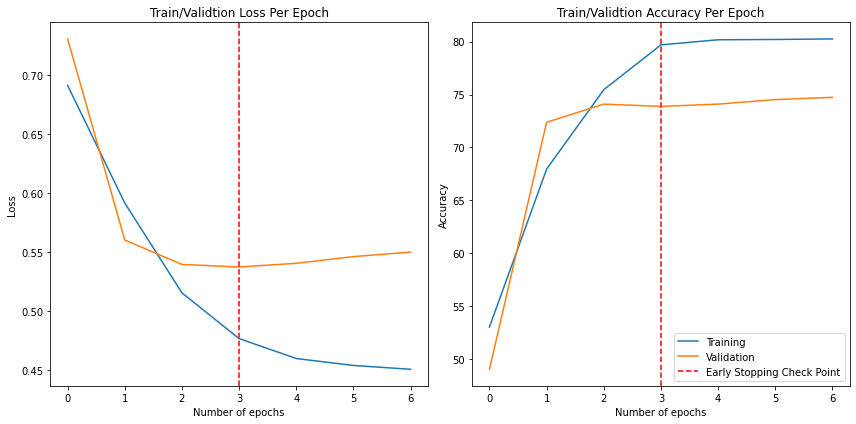


Training Session Info Stored


In [ ]:
seed_all(random_state = 60065)
hindi_encoder_cnn_tc.prepare_dataloaders(
    data_context = hindi_dc,
    train_percentage = 80,
    drop_last = False)
hindi_encoder_cnn_tc.train(model = hindi_encoder_cnn)

Test

In [ ]:
hindi_encoder_cnn_tc.test(model = hindi_encoder_cnn)

Test Accuracy: 72.53 %


# b) & c) Preprocess the Bengali data & Bengali word embeddings



### Workflow (Training Bengali Embedding):
0. Seed - for reproducibility
1. Define params
2. Create an instance of the embedding context class
3. Load data, sample & preprocess
5. Create vocabulary (is_dev = True to work with small dataset)
6. Convert vocabulary words to indicies
7. Precompute relative frequencies of the words
8. Create an instance of the Word2Vec model
4. Define and assign criterion and optimizer
9. (Seed again and then) Prepare dataloader
9. Train

To get an idea of the distribution

In [ ]:
hindi_dc.dataf.groupby([hindi_dc.dataf.task_1]).size()

task_1
HOF    2469
NOT    2196
dtype: int64

In the hindi dataset, there are around 2500 'HOF' and 2200 'NOT'. The bangla dataset contains way more sentences than the hindi dataset. The sentences are also devided into 7 categories. So, to get a sample that is similar to hindi in terms of distribution, and also that represent data from all the 7 categories of Bengali data, We sample the Bengali data in groups.

In [ ]:
rand_state = 60065
sampling_params = {
    "HATE": 360, # Around 2500 HOF, To equally sample from 7 categories, around 2500/7 ~ 360 rows per categories
    "NOT_HATE": 315, # Around 2200 NOT, To equally sample from 7 categories, around 2200/7 ~ 315 rows per categories
    "seed": rand_state,
}

# Step 0
seed_all(rand_state)

# Step 1
dev_params = {
    "batch_size": 64,
    "window_size": 2,
    "patience": 5,
    "dataset_name": "bn_dev",
    "learning_rate": 0.001,
    "epochs": 100,
}


The `EmbeddingContext` class reads the data paths creates a sample, takes the sampled data through the same preprocessing pipeline as done in Task 1, creates the vocabu, and after that using some intermediate steps, with the help of skip-grams, prepares the data loader for training. The class also contains a `train` method that trains the Word2Vec model.

In [ ]:
# Step 2
bn_ec = EmbeddingContext(dev_params)


Number of rows by categories in the original dataset:
category
Meme, TikTok and others    4236
celebrity                  3711
crime                      4763
entertainment              4527
politics                   3987
religion                   4370
sports                     4406
dtype: int64

Number of hate speeches by categories after sampling:
category
Meme, TikTok and others    360
celebrity                  360
crime                      360
entertainment              360
politics                   360
religion                   360
sports                     360
dtype: int64

Number of non hate speeches by categories after sampling:
category
Meme, TikTok and others    315
celebrity                  315
crime                      315
entertainment              315
politics                   315
religion                   315
sports                     315
dtype: int64

Number of combined sampled texts by categories:
category
Meme, TikTok and others    675
celebrity         

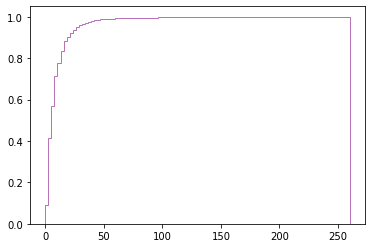

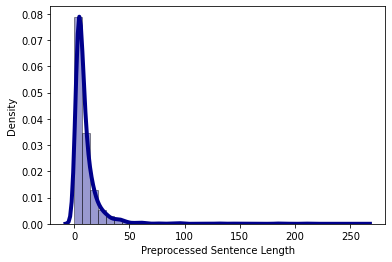

In [ ]:
# Step 3
bn_ec.load_and_preprocess_data(data_path = "data/bengali_hatespeech.csv", stopwords_path = "data/stopwords-bn.txt", data_delimiter = ',', sampling_params = sampling_params)

In [ ]:
# store sampled data for later use
bn_ec.dataf.to_csv('data/bengali_hatespeech_sampled.tsv', sep = '\t', index=False)
bn_ec.dataf.head()

,text,hate,category,preprocessed_sen_len
3837,সাধারণ মানুষ হয়ে বলব।কোথায় আসনে নির্বাচিত হয়ে ...,0,politics,12
4443,যারা অনলাইনে বেটিং করতে চান বা ক্রিকেট ফুটবল স...,0,sports,53
3956,যুক্তি সম্পূর্ণ কথা বলতে এবং শুনতে সত্যি ভালো ...,0,politics,10
4651,তোমার কোন দোষ নাই।।সাকিব ভাইকে খেলাতে দেখতে চাই।,0,sports,5
2551,উচ্চারণ ঠিক করেন,0,"Meme, TikTok and others",1


In [ ]:
# Step 4 | For now we are using is_dev = True, which will create a vocabulary with only 100 sentences, so that we can check the model learns.
bn_ec.build_vocab(is_dev = True)
# Step 5
bn_ec.convert_word_to_index()
# Step 6
bn_ec.calculate_relative_frequency()
# Step 7
bn_emmbeddings_dev = Word2Vec(bn_ec.ONE_HOT_VECTOR_SIZE, 300)
# Step 8
bn_ec.optimizer = torch.optim.Adam(bn_emmbeddings_dev.parameters(), lr = dev_params["learning_rate"])
bn_ec.criterion = nn.NLLLoss(reduction = "mean")


Vocabularies length: 767


In [ ]:
# Step 9
seed_all(rand_state)
bn_ec.prepare_dataloader()

Preparing data loader
Data loader is ready.
Found 3342 pairs.
Preparing Data Loader Took 0.01 Seconds




Training started

Avg. loss at epoch 1: 6.640747970005251
Validation loss decreased (inf --> 6.640748).  Saving model ...

Avg. loss at epoch 2: 6.574201223985204
Validation loss decreased (6.640748 --> 6.574201).  Saving model ...

Avg. loss at epoch 3: 6.480605755212172
Validation loss decreased (6.574201 --> 6.480606).  Saving model ...

Avg. loss at epoch 4: 6.322349035514976
Validation loss decreased (6.480606 --> 6.322349).  Saving model ...

Avg. loss at epoch 5: 6.065206851599352
Validation loss decreased (6.322349 --> 6.065207).  Saving model ...

Avg. loss at epoch 6: 5.67987100133356
Validation loss decreased (6.065207 --> 5.679871).  Saving model ...

Avg. loss at epoch 7: 5.170202273242879
Validation loss decreased (5.679871 --> 5.170202).  Saving model ...

Avg. loss at epoch 8: 4.572697135637391
Validation loss decreased (5.170202 --> 4.572697).  Saving model ...

Avg. loss at epoch 9: 3.9547621214164876
Validation loss decreased (4.572697 --> 3.954762).  Saving model ..

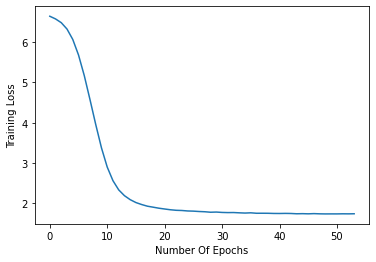

In [ ]:
# Step 10
bn_ec.train(bn_emmbeddings_dev)

# Train Bengali Embedding on the full dataset

FULL SET TRAINING STARTED
--------------------------------------------------
Vocabularies length: 14583


Calculating Relative Frequencies
Finished Calculation.
Calculation Took 13.32 Seconds


Preparing data loader
Data loader is ready.
Found 341810 pairs.
Preparing Data Loader Took 0.49 Seconds


Total batches: 668
Training started
....................
Avg. loss at epoch 1: 8.885835971660956
Validation loss decreased (inf --> 8.885836).  Saving model ...
....................
Avg. loss at epoch 2: 8.28855489328236
Validation loss decreased (8.885836 --> 8.288555).  Saving model ...
....................
Avg. loss at epoch 3: 7.670183139646839
Validation loss decreased (8.288555 --> 7.670183).  Saving model ...
....................
Avg. loss at epoch 4: 6.859002582327334
Validation loss decreased (7.670183 --> 6.859003).  Saving model ...
....................
Avg. loss at epoch 5: 6.145366680122422
Validation loss decreased (6.859003 --> 6.145367).  Saving model ...
....................

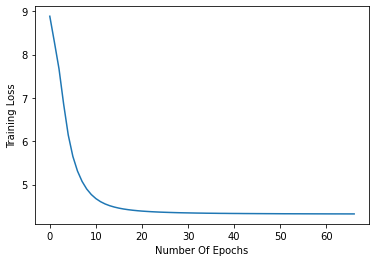




FULL SET TRAINING FINISHED
--------------------------------------------------


In [ ]:
print("FULL SET TRAINING STARTED\n" + str(''.join(['-'] * 50)))
# Step 0
seed_all(rand_state)

# Step 1
fullset_params = {
    "batch_size": 512,
    "window_size": 5,
    "patience": 5,
    "dataset_name": "bn_full",
    "learning_rate": 0.001,
    "epochs": 100,
}

# Step 2
bn_ec.params = fullset_params

# Step 3
# Done above

# Step 4
bn_ec.build_vocab(is_dev = False)
# Step 5
bn_ec.convert_word_to_index()

print("\n\nCalculating Relative Frequencies")
start = timeit.default_timer()

# Step 6
bn_ec.calculate_relative_frequency()

stop = timeit.default_timer()
print("Finished Calculation.\nCalculation Took " + str(round((stop - start), 2)) + " Seconds\n\n")

# Step 7
bn_emmbeddings = Word2Vec(bn_ec.ONE_HOT_VECTOR_SIZE, 300)
# Step 8
bn_ec.optimizer = torch.optim.Adam(bn_emmbeddings.parameters(), lr = fullset_params["learning_rate"])
bn_ec.criterion = nn.NLLLoss(reduction = "mean")

# Step 9
seed_all(rand_state)
bn_ec.prepare_dataloader()
print(f"Total batches: {len(bn_ec.train_loader)}")

# Step 10
bn_ec.train(bn_emmbeddings, print_step = int(len(bn_ec.train_loader)/20))


print("FULL SET TRAINING FINISHED\n" + str(''.join(['-'] * 50)))

# Part (d)

# Apply the pretrained classifier to Bengali data

Preprocessing started
Preprocessing finished.
Preprocessing Took 0.6121324869999967 Seconds


count    4725.000000
mean       10.202540
std        13.961838
min         0.000000
25%         4.000000
50%         7.000000
75%        12.000000
max       260.000000
Name: preprocessed_sen_len, dtype: float64


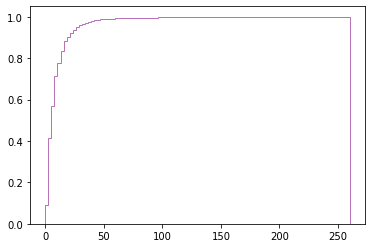


Vocabularies length: 14583


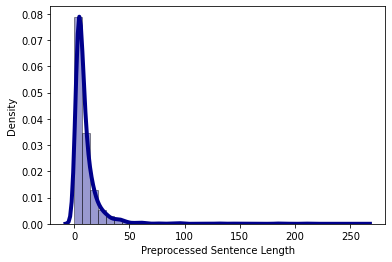

In [ ]:
bangla_dc = DataContext()
bangla_dc.load_and_preprocess_data("data/bengali_hatespeech_sampled.tsv", "data/stopwords-bn.txt", "\t")
bangla_dc.create_target(label_colum_name = "hate", positive_value = 1)
bangla_dc.build_vocab()
bangla_dc.convert_word_to_index()

Load Bengali Word2Vec embedding

In [ ]:
bangla_w2v = Word2Vec(bangla_dc.ONE_HOT_VECTOR_SIZE, embedding_size = 300)
nnc.load_model(bangla_w2v, "Word2Vec/bengali_full_w2v.pt")
bangla_emb = bangla_w2v.E.weight.T.detach()
print(bangla_w2v)

Word2Vec(
  (E): Linear(in_features=14583, out_features=300, bias=False)
  (W): Linear(in_features=300, out_features=14583, bias=True)
)


In [ ]:
bangla_params = {
    "padding_idx" : 0,
    "sent_len" : 32,
    "batch_size" : 4,
    "patience" : 3,
    "dataset_name" : "bangla",
    "weight_decay" : 1e-6,
    "epochs" : 100,
    "learning_rate" : 1e-4,
    "milestones" : [3, 9],
    "gamma" : 0.01,
    "hidden_wieghts_dim": 100,
    "num_of_layers": 2,
    "num_of_classes": 1,
    "drop_prob": 0.35,
    "number_of_fc": 1,
    "conv_params": [
        [1, 32, (1, 13), 1, 0],
        [32, 64, (1, 25), 1, 0],
        [64, 128, (1, 35), 1, 0]
    ]
}

Create an model for Bengali Classifier from the pretrained Hindi classifier (copy all the weights and replace the embadding metrix with Bengali embedding)

In [ ]:
import copy
hindi_trained = EncoderCNN(Embedding = hindi_emb, params = hindi_params)
nnc.load_model(hindi_trained, "EncoderCNN/hindi_encoder_cnn.pt")
bangla_encoder_cnn_from_hindi = EncoderCNN(Embedding = bangla_emb, params = bangla_params)
bangla_encoder_cnn_from_hindi.lstm = copy.deepcopy(hindi_trained.lstm)
bangla_encoder_cnn_from_hindi.conv1 = copy.deepcopy(hindi_trained.conv1)
bangla_encoder_cnn_from_hindi.pool1 = copy.deepcopy(hindi_trained.pool1)
bangla_encoder_cnn_from_hindi.conv2 = copy.deepcopy(hindi_trained.conv2)
bangla_encoder_cnn_from_hindi.pool2 = copy.deepcopy(hindi_trained.pool2)
bangla_encoder_cnn_from_hindi.conv3 = copy.deepcopy(hindi_trained.conv3)
bangla_encoder_cnn_from_hindi.fc = copy.deepcopy(hindi_trained.fc)

Output shape after conv1: (16, 94)
Output shape after conv2: (8, 35)
Output shape after conv3: (8, 1)
Output shape after conv1: (16, 94)
Output shape after conv2: (8, 35)
Output shape after conv3: (8, 1)


In [ ]:
print(bangla_encoder_cnn_from_hindi)

EncoderCNN(
  (embedding): Embedding(14583, 300, padding_idx=0)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(1, 13), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 25), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(1, 35), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Do they have the same weights? Yes

In [ ]:
print(bangla_encoder_cnn_from_hindi is hindi_trained)
bangla_encoder_cnn_from_hindi.fc.weight == hindi_trained.fc.weight

False


tensor([[True, True, True,  ..., True, True, True]])

In [ ]:
bangla_encoder_cnn_tc = TrainingContext(bangla_params)

bangla_encoder_cnn_tc.criterion = nn.BCELoss()
seed_all(60065)
bangla_encoder_cnn_tc.optimizer = torch.optim.Adam(
    # [
    #     {"params": bangla_dnn_with_encoder_from_hindi.lstm.parameters(), "lr": 1e-5},
    #     {"params": bangla_dnn_with_encoder_from_hindi.conv1.parameters(), "lr": 1e-4},
    #     {"params": bangla_dnn_with_encoder_from_hindi.pool1.parameters(), "lr": 1e-4},
    #     {"params": bangla_dnn_with_encoder_from_hindi.conv2.parameters(), "lr": 1e-4},
    #     {"params": bangla_dnn_with_encoder_from_hindi.pool2.parameters(), "lr": 1e-4},
    #     {"params": bangla_dnn_with_encoder_from_hindi.conv3.parameters(), "lr": 1e-4},
    #     {"params": bangla_dnn_with_encoder_from_hindi.fc.parameters(), "lr": 1e-4},
    # ],
    bangla_encoder_cnn_from_hindi.parameters(),
    lr = bangla_params["learning_rate"],
    weight_decay = bangla_params["weight_decay"])

bangla_encoder_cnn_tc.scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bangla_encoder_cnn_tc.optimizer,
    milestones = bangla_params["milestones"],
    gamma = bangla_params["gamma"])

Running On GPU


Test on Bengali Data

In [ ]:
bangla_encoder_cnn_from_hindi.to(nnc.get_device(log = True))
seed_all(random_state = 60065)
bangla_encoder_cnn_tc.prepare_dataloaders(
    data_context = bangla_dc,
    train_percentage = 80,
    drop_last = True)
bangla_encoder_cnn_tc.test(bangla_encoder_cnn_from_hindi)

Running On GPU
Preparing data loader
Size of Training Set :3780, Validation Set: 473, and Test Set: 472
Data loader is ready.
Processed 4725 sentences.
Preparing Data Loader Took 0.04 Seconds


Test Accuracy: 50.85 %


# Retrain the same model. (This model already knows about the hindi data)

Training started
...................
At epoch 0:
		Learning Rate: .0001
		Avg. training loss: 0.69		Avg. training accuracy: 54.34
		Avg. validation loss: 0.66		Avg. validation accuracy: 63.98
		Validation loss decreased (inf --> 0.659008).  Saving model ...
...................
At epoch 1:
		Learning Rate: .0001
		Avg. training loss: 0.62		Avg. training accuracy: 64.68
		Avg. validation loss: 0.57		Avg. validation accuracy: 71.40
		Validation loss decreased (0.659008 --> 0.567738).  Saving model ...
...................
At epoch 2:
		Learning Rate: .0001
		Avg. training loss: 0.55		Avg. training accuracy: 71.46
		Avg. validation loss: 0.55		Avg. validation accuracy: 70.97
		Validation loss decreased (0.567738 --> 0.552334).  Saving model ...
...................
At epoch 3:
		Learning Rate: .000001
		Avg. training loss: 0.50		Avg. training accuracy: 75.95
		Avg. validation loss: 0.55		Avg. validation accuracy: 72.03
		Validation loss decreased (0.552334 --> 0.547344).  Saving model ...
..

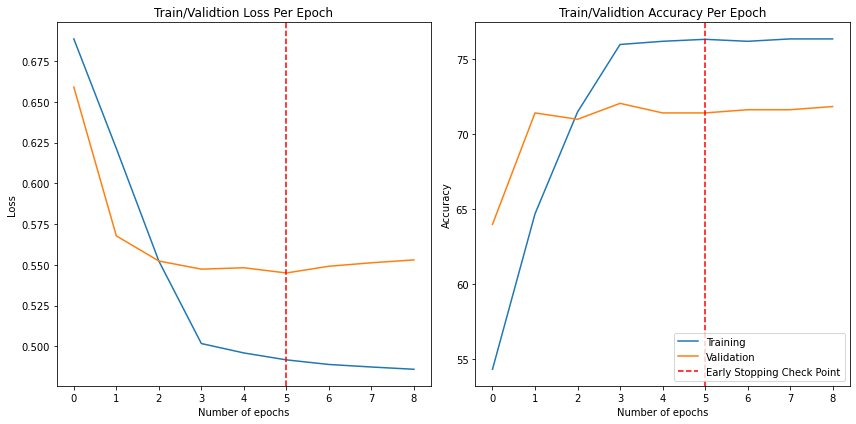


Training Session Info Stored


In [ ]:
bangla_encoder_cnn_tc.train(model = bangla_encoder_cnn_from_hindi)

# Transfer Learning Test: After training the pretrained Hindi Model with Bangla Data

In [ ]:
bangla_encoder_cnn_tc.test(model = bangla_encoder_cnn_from_hindi)

Test Accuracy: 71.03 %


# Training a Completely new model with Bengali Dataset

In [ ]:
bangla_params_new = {
    "padding_idx" : 0,
    "sent_len" : 32,
    "batch_size" : 4,
    "patience" : 3,
    "dataset_name" : "bangla_new",
    "weight_decay" : 1e-6,
    "epochs" : 100,
    "learning_rate" : 1e-4,
    "milestones" : [3, 9],
    "gamma" : 0.01,
    "hidden_wieghts_dim": 100,
    "num_of_layers": 2,
    "num_of_classes": 1,
    "drop_prob": 0.35,
    "number_of_fc": 1,
    "conv_params": [
        [1, 32, (1, 13), 1, 0],
        [32, 64, (1, 25), 1, 0],
        [64, 128, (1, 35), 1, 0]
    ]
}

In [ ]:
bangla_encoder_cnn = EncoderCNN(Embedding = bangla_emb, params = bangla_params_new)

Output shape after conv1: (16, 94)
Output shape after conv2: (8, 35)
Output shape after conv3: (8, 1)


In [ ]:
bangla_encoder_cnn_tc = TrainingContext(bangla_params_new)

bangla_encoder_cnn_tc.criterion = nn.BCELoss()
seed_all(60065)
bangla_encoder_cnn_tc.optimizer = torch.optim.Adam(
    bangla_encoder_cnn.parameters(),
    lr = bangla_params_new["learning_rate"],
    weight_decay = bangla_params_new["weight_decay"])

bangla_encoder_cnn_tc.scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bangla_encoder_cnn_tc.optimizer,
    milestones = bangla_params_new["milestones"],
    gamma = bangla_params_new["gamma"])

Running On GPU


Preparing data loader
Size of Training Set :3780, Validation Set: 473, and Test Set: 472
Data loader is ready.
Processed 4725 sentences.
Preparing Data Loader Took 0.05 Seconds


Training started
...................
At epoch 0:
		Learning Rate: .0001
		Avg. training loss: 0.69		Avg. training accuracy: 53.04
		Avg. validation loss: 0.69		Avg. validation accuracy: 51.69
		Validation loss decreased (inf --> 0.694514).  Saving model ...
...................
At epoch 1:
		Learning Rate: .0001
		Avg. training loss: 0.61		Avg. training accuracy: 66.06
		Avg. validation loss: 0.61		Avg. validation accuracy: 65.47
		Validation loss decreased (0.694514 --> 0.608799).  Saving model ...
...................
At epoch 2:
		Learning Rate: .0001
		Avg. training loss: 0.56		Avg. training accuracy: 70.42
		Avg. validation loss: 0.61		Avg. validation accuracy: 67.58
		EarlyStopping counter: 1 out of 3
...................
At epoch 3:
		Learning Rate: .000001
		Avg. training loss: 0.53		Avg. training accurac

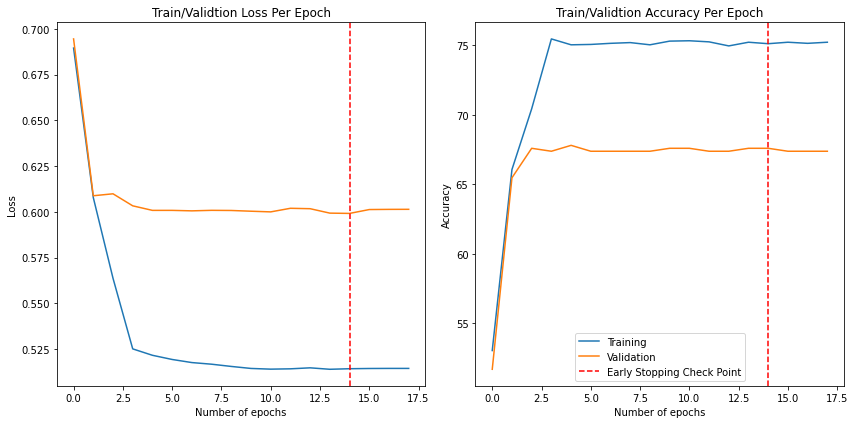


Training Session Info Stored


In [ ]:
seed_all(random_state = 60065)
bangla_encoder_cnn_tc.prepare_dataloaders(
    data_context = bangla_dc,
    train_percentage = 80,
    drop_last = True)
bangla_encoder_cnn_tc.train(bangla_encoder_cnn)

In [ ]:
bangla_encoder_cnn_tc.test(model = bangla_encoder_cnn)

Test Accuracy: 68.03 %


### Sentiment Classifiers and their train, validation and test accuracy summary

| Model Description                       | Train Accuracy | Validation Accuracy | Test Accuracy |
|-----------------------------------------|----------------|---------------------|---------------|
| EncoderCNN Models                       |                |                     |               |
| Hindi                                   | 79.69 %        | 73.88 %             | 72.53 %       |
| Hindi classifier on Bengali Data        | NA             | NA                  | 50.85 %       |
| Bengali trained on top of Hindi weights | 76.30 %        | 71.40 %             | 71.03 %       |
| Bengali trained with only Bengali Data  | 75.11 %        | 67.58 %             | 68.03 %       |